In [3]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F 
from torch import nn,optim
from torchvision import transforms as T,datasets,models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
pd.options.plotting.backend = "plotly"
from torch import nn, optim
from torch.autograd import Variable

In [4]:
def data_transforms(phase = None):
    
    if phase == TRAIN:

        data_T = T.Compose([
            
                T.Resize(size = (256,256)),
                T.RandomRotation(degrees = (-20,+20)),
                T.CenterCrop(size=224),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    elif phase == TEST or phase == VAL:

        data_T = T.Compose([

                T.Resize(size = (224,224)),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    return data_T

In [5]:
data_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

trainset = datasets.ImageFolder(os.path.join(data_dir, TRAIN),transform = data_transforms(TRAIN))
testset = datasets.ImageFolder(os.path.join(data_dir, TEST),transform = data_transforms(TEST))
validset = datasets.ImageFolder(os.path.join(data_dir, VAL),transform = data_transforms(VAL))

In [6]:
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [7]:
trainloader = DataLoader(trainset,batch_size = 64,shuffle = True)
validloader = DataLoader(validset,batch_size = 64,shuffle = True)
testloader = DataLoader(testset,batch_size = 64,shuffle = True)

images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [8]:
for i, (images,labels) in enumerate(trainloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

In [9]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [10]:
class classify(nn.Module):
    def __init__(self,num_classes=2):
        super(classify,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()        
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=32 * 112 * 112,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)            
        output=output.view(-1,32*112*112)
        output=self.fc(output)
            
        return output
    
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
!pip install torchsummary
from torchsummary import summary
summary(classify().cuda(), (images.shape[1], images.shape[2], images.shape[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 224, 224]             336
       BatchNorm2d-2         [-1, 12, 224, 224]              24
              ReLU-3         [-1, 12, 224, 224]               0
         MaxPool2d-4         [-1, 12, 112, 112]               0
            Conv2d-5         [-1, 20, 112, 112]           2,180
              ReLU-6         [-1, 20, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]           5,792
       BatchNorm2d-8         [-1, 32, 112, 112]              64
              ReLU-9         [-1, 32, 112, 112]               0
           Linear-10                    [-1, 2]         802,818
Total params: 811,214
Trainable params: 811,214
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 27.95
Params size (MB): 3.09
Estimated 

In [12]:
model = classify()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [13]:
Losses = []
for i in range(10):
    running_loss = 0
    for images, labels in trainloader:
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        Losses.append(loss)
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 37.90554365515709
Epoch 2 - Training loss: 9.655484017075562
Epoch 3 - Training loss: 6.147702271441032
Epoch 4 - Training loss: 2.965347083785185
Epoch 5 - Training loss: 1.2591694422090045
Epoch 6 - Training loss: 0.5702827466742658
Epoch 7 - Training loss: 0.2390885387161156
Epoch 8 - Training loss: 0.15174754203592494
Epoch 9 - Training loss: 0.13735299915211593
Epoch 10 - Training loss: 0.13219720395509063


In [14]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 3, 224, 224)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 624

Model Accuracy = 0.842948717948718


Epoch 1 - Training loss: 0.1270, Validation accuracy: 0.6875
Epoch 2 - Training loss: 0.1171, Validation accuracy: 0.6875
Epoch 3 - Training loss: 0.1137, Validation accuracy: 0.6875
Epoch 4 - Training loss: 0.1156, Validation accuracy: 0.5625
Epoch 5 - Training loss: 0.1246, Validation accuracy: 0.6250
Epoch 6 - Training loss: 0.1119, Validation accuracy: 0.5000
Epoch 7 - Training loss: 0.1177, Validation accuracy: 0.6250
Epoch 8 - Training loss: 0.1234, Validation accuracy: 0.6875
Epoch 9 - Training loss: 0.1236, Validation accuracy: 0.5625
Epoch 10 - Training loss: 0.1199, Validation accuracy: 0.5625


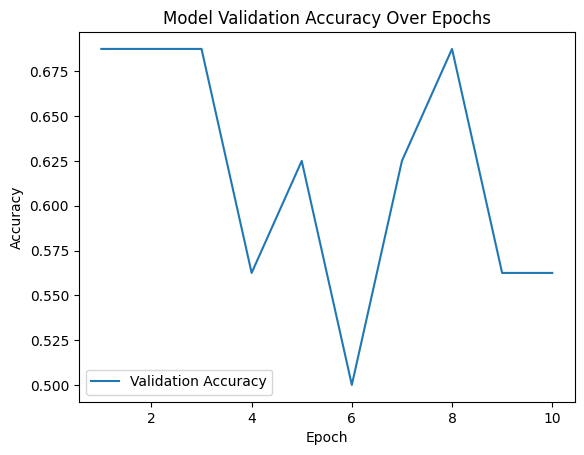

In [15]:
accuracies = []

for epoch in range(10):
    running_loss = 0
    correct_count = 0
    total_count = 0
    
    for images, labels in trainloader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in validloader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            output = model(images)
            _, predicted = torch.max(output, 1)
            total_count += labels.size(0)
            correct_count += (predicted == labels).sum().item()

    model.train()
    accuracy = correct_count / total_count
    accuracies.append(accuracy)
    print("Epoch {} - Training loss: {:.4f}, Validation accuracy: {:.4f}".format(epoch + 1, running_loss / len(trainloader), accuracy))

plt.plot(range(1, 11), accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Validation Accuracy Over Epochs')
plt.legend()
plt.show()